# Creating a GHZ state with IQM Garnet

Creating a GHZ state is a great first job to run on IQM Garnet as your first circuit.

In this notebook, you will learn how to ...
* ... verify genuine multi-qubit entanglement by measuring the fidelity of the GHZ state using the multiple quantum coherence method.

By the end of this notebook, you will not only have a solid understanding of how to execute a circuit on IQM Garnet, but you will also appreciate the subtleties that differentiate various quantum computing architectures and their impact on quantum information processing. This exploration will provide you with the skills that are essential for advancing with this new quantum computing architecture and making full use of the computational resonator to advance the field of quantum computing.

### Installing the necessary packages
In order to get started, make sure you have the appropriate packages installed:

In [1]:
%%capture
!pip install "iqm-client[qiskit]"
!pip install networkx
!pip install rustworkx
!pip install matplotlib
!pip install pylatexenc

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

In [2]:
import os
os.environ["IQM_TOKEN"] = input()

## Connecting to IQM Garnet

Let's first check that our connection is working.

We do this by authenticating ourselves to IQM Resonance.

In [3]:
from iqm.qiskit_iqm import IQMProvider

# Instead of setting the environment variable, you could add the token as an argument to the IQMProvider constructor
provider=IQMProvider(url="https://cocos.resonance.meetiqm.com/garnet") 
backend = provider.get_backend()

Then we can access the IQM Garnet backend and plot its connectivity graph to check that everything is working properly.

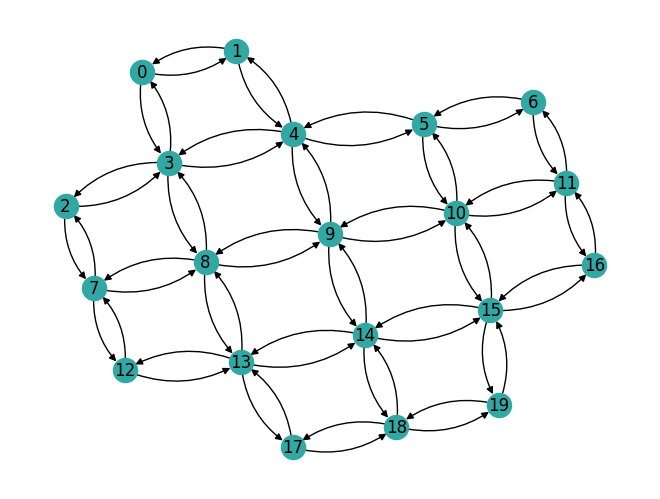

In [4]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## Creating the GHZ state using a simulator

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1. We will use 10 qubits of the 20, we have available on IQM Garnet, this can be represented as:

$$\frac{1}{\sqrt{2}}(∣000000000⟩+ ∣111111111⟩)$$

If we want to create a GHZ state for a simulator without considering connectivity constraints given by actual quantum computing hardware, we can just do the folllowing:

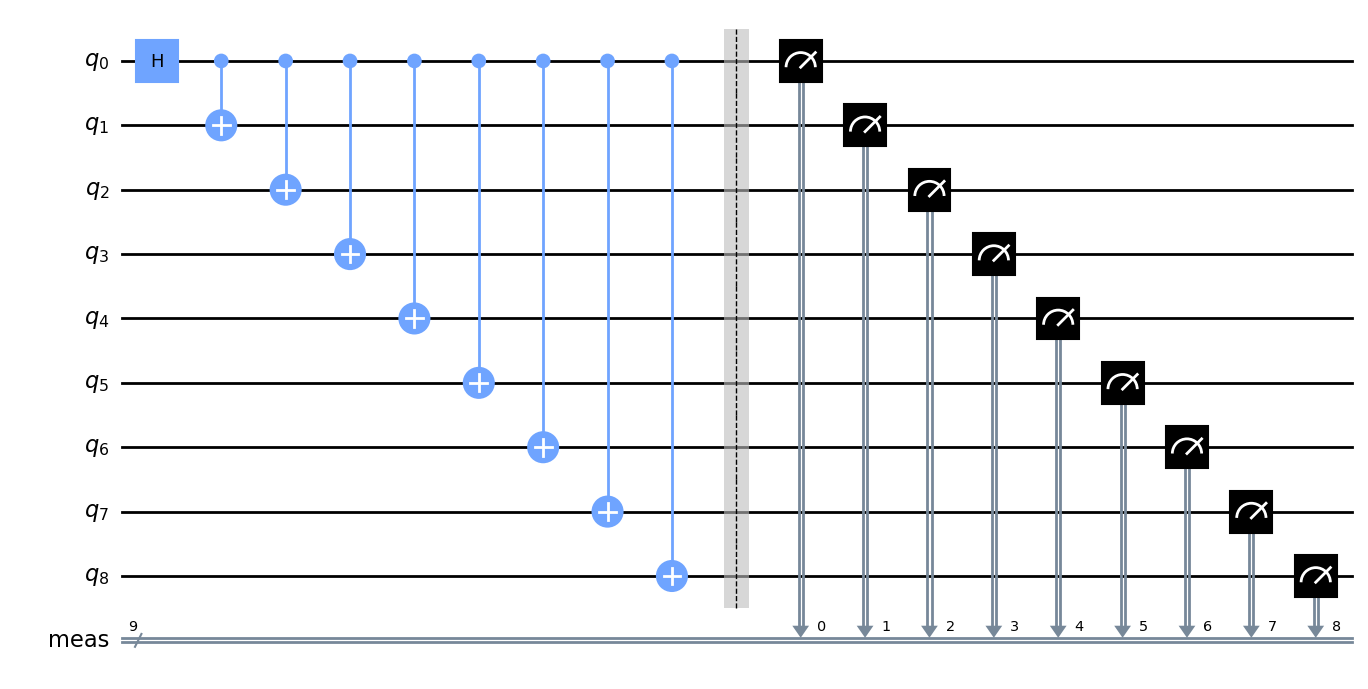

In [5]:
from qiskit import QuantumCircuit

num_qb = 9
qc = QuantumCircuit(num_qb)

qc.h(0)
for qb in range(1, num_qb):
    qc.cx(0, qb)

qc.measure_all()
qc.draw("mpl",  style="clifford")

## Creating the GHZ state with IQM Garnet

When adapting GHZ state generation to the square lattice topology, as seen in IQM Garnet, we can tune our circuit to

In order to create a GHZ state, we follow the steps below:

<ol>
<li> First, we initiate the process by <b>creating a superposition</b> using a Hadamard gate <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">H</span> on a qubit.
</li>
<li>  Then, we <b>apply <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gates from one qubit to three other qubits to utilize the connectivity of a square grid</b>.
</li>
<li> Finally, we perform <b>measurements on all qubits. 
</li>
</ol>

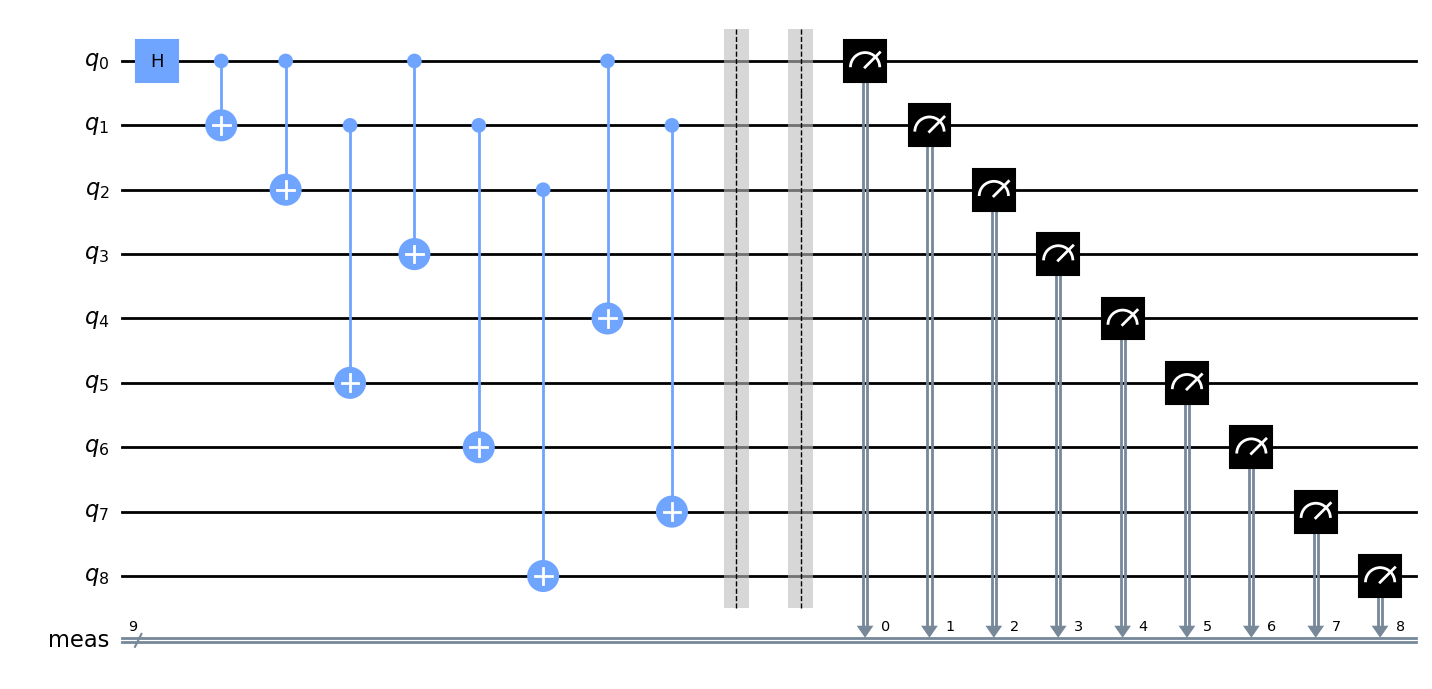

In [6]:
from qiskit import transpile
from qiskit.visualization import plot_histogram

# Create Quantum Registers and Quantum Circuit
qc = QuantumCircuit(num_qb)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.cx(0, 3)
qc.cx(0, 4)
qc.cx(1, 5)
qc.cx(1, 6)
qc.cx(1, 7)
qc.cx(2, 8)

qc.barrier()
qc.measure_all()
qc.draw("mpl", style="clifford")


<div style="background-color: white; margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);">
With the circuit prepared, we can now send it to our quantum computer and examine the results. The execute function will carry out several transpilation steps, including decomposing the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gate into native gates.
</div>

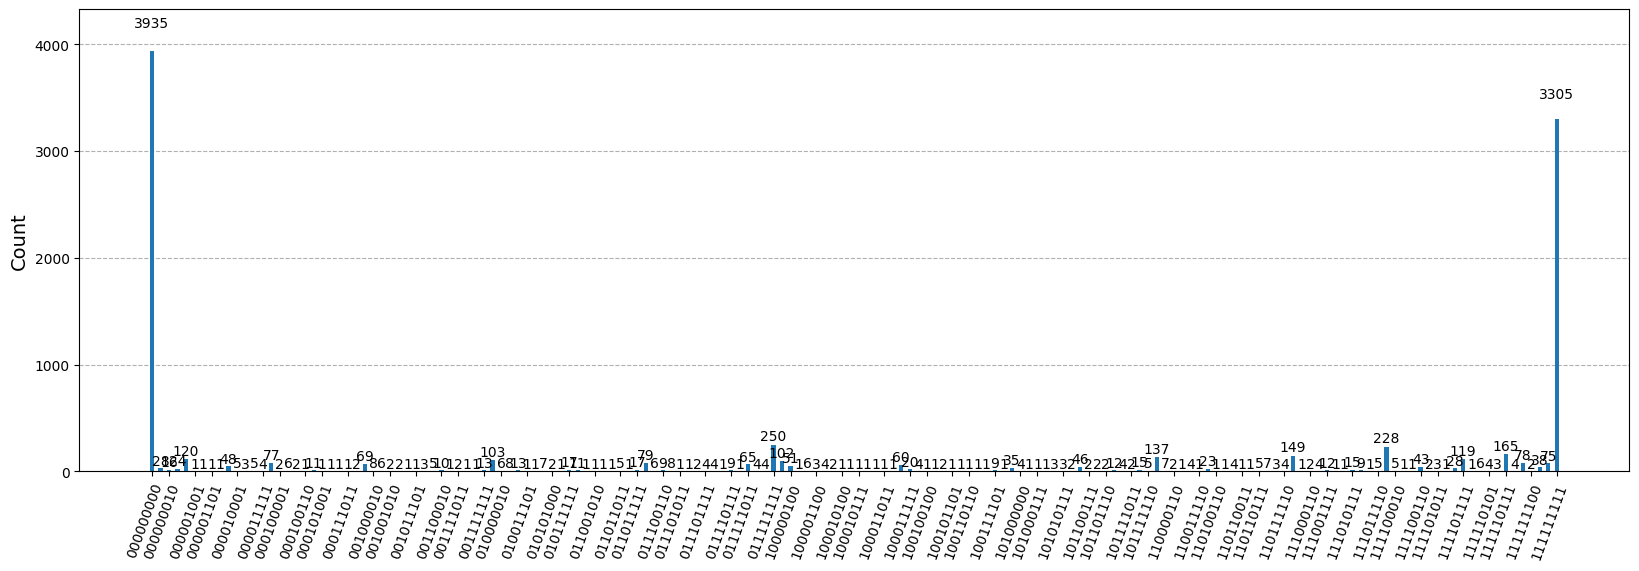

In [7]:
shots = 10000
qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=shots)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)


res=job.result()
counts=res.get_counts()

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

The result looks indeed like a GHZ state: We observe two distinct peaks corresponding to the bitstrings composed entirely of zeros and entirely of ones. The remaining counts are indicative of noise and errors within the system. 

As the plot is quite hard to read with all the different possible outcomes, let's only check how many out of our 10,000 shots actually turned out to be $∣00000000000⟩$ or $∣11111111111⟩)$. For this, we can sort the results obtained and see that we have around 6500 shots of the 10.000 that yielded either all zeros or all ones.

In [8]:
# sort the counts
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
sorted_counts

{'000000000': 3935,
 '111111111': 3305,
 '011111111': 250,
 '111011111': 228,
 '111110111': 165,
 '110111111': 149,
 '101111111': 137,
 '000001000': 120,
 '111101111': 119,
 '010000000': 103,
 '100000000': 102,
 '011100010': 79,
 '111111011': 78,
 '000100000': 77,
 '111111110': 75,
 '001000000': 69,
 '011111011': 65,
 '100011101': 60,
 '100000100': 51,
 '000010000': 48,
 '101011111': 46,
 '111100110': 43,
 '111111101': 38,
 '100111111': 35,
 '000000001': 28,
 '111101110': 28,
 '000000100': 24,
 '110011111': 23,
 '100011111': 20,
 '010111111': 17,
 '011011111': 17,
 '000000010': 16,
 '111010111': 15,
 '101111101': 15,
 '001111111': 13,
 '010010000': 13,
 '111001111': 12,
 '101101111': 12,
 '011000010': 11,
 '000101000': 11,
 '001100010': 10,
 '111011011': 9,
 '011110111': 9,
 '100111101': 9,
 '011100110': 9,
 '011101010': 8,
 '001000010': 8,
 '010001000': 8,
 '110111011': 7,
 '010100010': 7,
 '110000000': 7,
 '001001000': 6,
 '010000010': 6,
 '000100010': 6,
 '011100011': 6,
 '100001000

## Verifying genuine multi-qubit entanglement by measuring the GHZ state fidelity

The GHZ state fidelity acts as a witness for genuine multi-qubit entanglement if found to be above $0.5$ (more precisely, it has been shown that this is equivalent to measuring a negative expectation value of a multipartite entanglement witness - see [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta) and references therein). This means that the measurement results cannot be explained without entanglement involving all qubits, so it is a great way to evaluate the "quantumness" of the computer. 

The fidelity of a mixed state is computed using the [formula](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) 
$$F(\text{ideal}, \text{measured})= \left(\text{Tr}\sqrt{\sqrt{\rho_{\text{ideal}}}\rho_{\text{measured}}\sqrt{\rho_{\text{ideal}}}}\right)^2$$

where $\rho_{\text{ideal}}$ is the density matrix of an ideal GHZ state (i.e. without noise) and $\rho_{\text{measured}}$ is the density matrix as given by the actual results of the quantum computer. The ideal GHZ state density matrix only has non-zero entries in the four corners of the density matrix $|00...0\rangle\langle00...0|$, $|00...0\rangle \langle11...1|$, $|11...1\rangle \langle00...0|$, $|11...1\rangle \langle11...1|$. This simplifies the process since we only need to measure these four components. In the fidelity formula, all other entries are effectively nullified by the zero entries in the ideal state matrix. 

From the experiment above we obtained the diagonal elements of $\rho_{\text{measured}}$, but we still need to measure the coherences along the anti-diagonal. We will use the method of multiple quantum coherences to measure these off-diagonal entries [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta). 

This method leverages the fact that for a GHZ state, a phase rotation $e^{i\phi}$ applied to all $n$ qubits results in the $|11...1\rangle$ component acquiring a cumulative phase of $e^{in\phi}$. The $|00...0\rangle$ component remains unaffected by this phase rotation and does not accumulate any phase. To measure this, we generate a GHZ state, apply phase shifts to all qubits, and then attempt to reverse the state using the circuit that initially created the GHZ state. From this, we can then observe the oscillation of the probability of the $|00...0\rangle$ component as we scan the phase angle from $0$ to $2\pi$. By fourier transforming the signal we can extract the amplitude of the oscillation happening at frequency $n$, which is a measure of the $|00...0\rangle \langle11...1|,|11...1 \rangle \langle00...0|$ coherences.

In order to perform these measurements, we first need to generate the phase-shifter circuits used in the method of multiple quantum coherences. We will create $2n+2$ of these circuits, which is the maximal step-size for detecting a signal oscillating at frequency $n$ according to the [Nyquist–Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). 

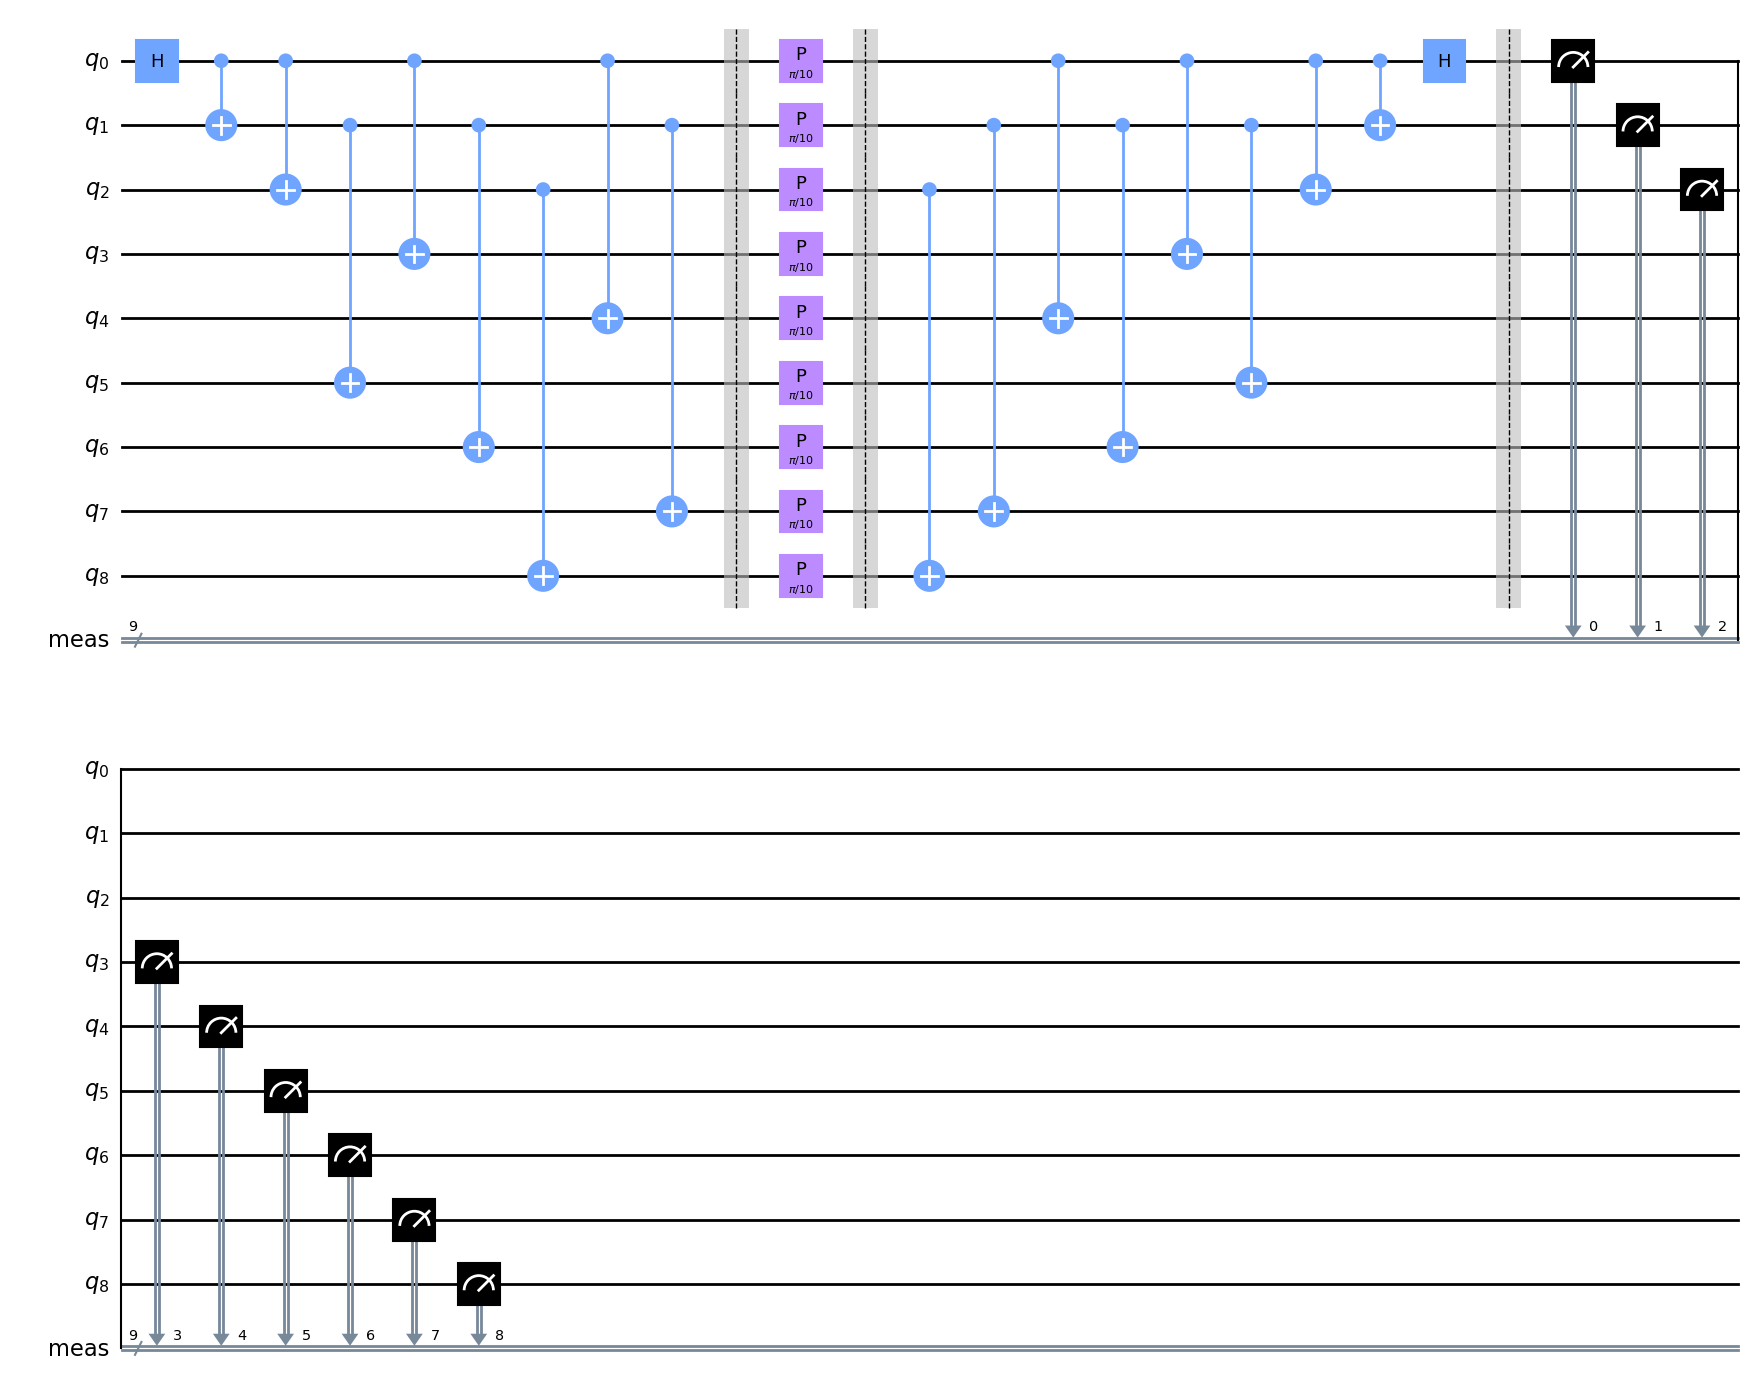

In [9]:
import numpy as np

phases=[np.pi*i/(num_qb +1) for i in range(2*num_qb+2)] # Creating phase shifts at intervals 1/(2n+2)

circuits=[]
for phase in phases: 
    qc = QuantumCircuit(num_qb)
    
    # Creating a GHZ state
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(0, 3)
    qc.cx(0, 4)
    qc.cx(1, 5)
    qc.cx(1, 6)
    qc.cx(1, 7)
    qc.cx(2, 8)


    qc.barrier()
    #adding phases
    for i in range(num_qb):
        qc.p(phase,i)
    qc.barrier()
    
    # Undoing GHZ can be acchieved by applying the same operations as above in reverse order
    qc.cx(2, 8)
    qc.cx(1, 7)
    qc.cx(1, 6)
    qc.cx(1, 5)
    qc.cx(0, 4)
    qc.cx(0, 3)
    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.h(0)
    #measure
    qc.measure_all()
    circuits.append(qc)

# Draw a circuit as an example
circuits[1].draw('mpl', style="clifford")

Now we are ready to send our circuits to the quantum computer. Instead of sending them individually, we can send them all at once in a single batch for faster execution. A batch is a list that contains several circuits and, under most circumstances, is more time-efficient.

In [10]:
all_counts = []
for circ in circuits:
    circ_transpiled = transpile(circ, backend)
    job = backend.run(circ_transpiled, shots=shots)
    all_counts.append(job.result().get_counts())

# Alternatively we can submit it as a batch
#circuits_transpiled = list(map(lambda circ: transpile(circ, backend), circuits))
#job = backend.run(circuits_transpiled, shots=shots)
#all_counts = job.result().get_counts() # Retrieve the list of counts from the batch job result



With our job completed, we can collect the results from IQM Garnet and use them to calculate the coherences and the fidelity of the GHZ state.

In [11]:
all_zero_probability_list=[] # An ordered list for storing the probabilites of returning to the |00..0> state

for count in all_counts:
    probability = count['0'*num_qb]/shots
    all_zero_probability_list.append(probability)

# Computing the phase acquired by the |11...1> component for each interval
complex_coefficients = np.exp(1j*num_qb*np.array(phases))

# Extracting coherence parameter i_n using the fourier transform
i_n = np.abs(np.dot(complex_coefficients,np.array(all_zero_probability_list)))/(len(phases)) 

# Extracting the probabilites of the 00...0 and 11...1 bitstrings 
# from the results of the first half of this notebook
counts_direct = res.get_counts()
probs_direct = {label: count / shots for label, count in counts_direct.items()}

# Computing GHZ state fidelity from i_n and the probabilites according to the method in [Mooney, 2021]
fidelity=(probs_direct['0'*num_qb]+probs_direct['1'*num_qb] + 2 * np.sqrt(i_n))/2

print("Measured GHZ Fidelity = " + str(fidelity))

Measured GHZ Fidelity = 0.7411574496576232


This result shows us that we have created a GHZ-state with fidelity $>0.5$, certifying the "quantumness" of the device through genuine multi-qubit entanglement. The measurement results cannot be explained through fewer then 9 qubits entangled.

Now it's your turn, take the code above to create an even bigger GHZ state and measure its fidelity. You can also experiment further and apply error mitigation schemes to reduce these errors. Don't forget to consider the qubit layout.

In [12]:

# Copyright 2024 IQM Quantum Computers (Hermanni Heimonen, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.